In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [110]:
topdirs = {5:"../../data/Run5/", 6:"../../data/Run6/", 7:"../../data/Run7/", 8:"../../data/Run8/", 9:"../../data/Run9/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [111]:
#load data into mem if you want
for n, ana in anas.items():
    if(n==5 or n == 6): continue
    ana.load_dataframe()

## PMT Amplitudes

In [ ]:
#reproduce some of the plots above
for run, ana in anas.items():
    d = ana.df
    fig, ax = plt.subplots()
    h = np.array(d["ch0 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 0", alpha=0.6)

    h = np.array(d["ch1 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 1", alpha=0.6)

    ax.legend()
    ax.set_xlabel("primary pulse amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("All PMT primary amplitudes in run {:d} ({:d} events)".format(run, len(h)))
    ax.set_yscale('log')
    plt.show()

In [ ]:
d = anas[7].df

fig, ax = plt.subplots()
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="All PMT events during HV ramping")

d = ds.reduced_df
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="Cosmics no HV")


ax.legend(markerscale=8)
ax.set_ylim([-1, 6])
ax.set_xlim([0, 200])
ax.set_xlabel("primary pulse amplitude [mV]")
ax.set_ylabel("primary pulse integral [mV*us]")
ax.set_title("All of Run 7 PMT events, at 0V and HV ramping separated")
#ax.set_yscale('log')
plt.show()

In [ ]:
for run, ana in anas.items():
    d = ana.df
    ch0_int = np.array(d["ch0 afterpulse integral"])
    ch0_int = ch0_int[~np.equal(ch0_int, None)]
    ch0_base = np.array(d["ch0 postbaseline"])
    ch0_base = 7.5*ch0_base[~np.equal(ch0_base, None)]
    ch0_int = ch0_int - ch0_base

    ch1_int = np.array(d["ch1 afterpulse integral"])
    ch1_int = ch1_int[~np.equal(ch1_int, None)]
    ch1_base = np.array(d["ch1 postbaseline"])
    ch1_base = 7.5*ch1_base[~np.equal(ch1_base, None)]
    ch1_int = ch1_int - ch1_base

    total_int = ch1_int + ch0_int

    fig, ax = plt.subplots()
    ax.hist(total_int, 100)
    ax.set_yscale('log')
    plt.show()


## Anode charge

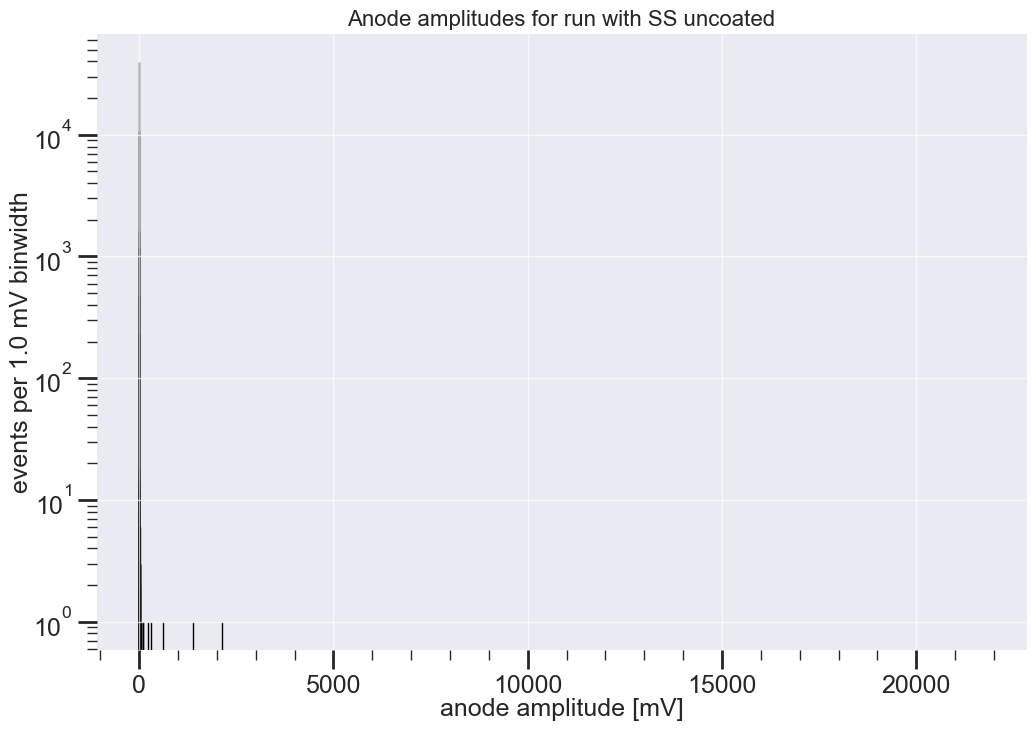

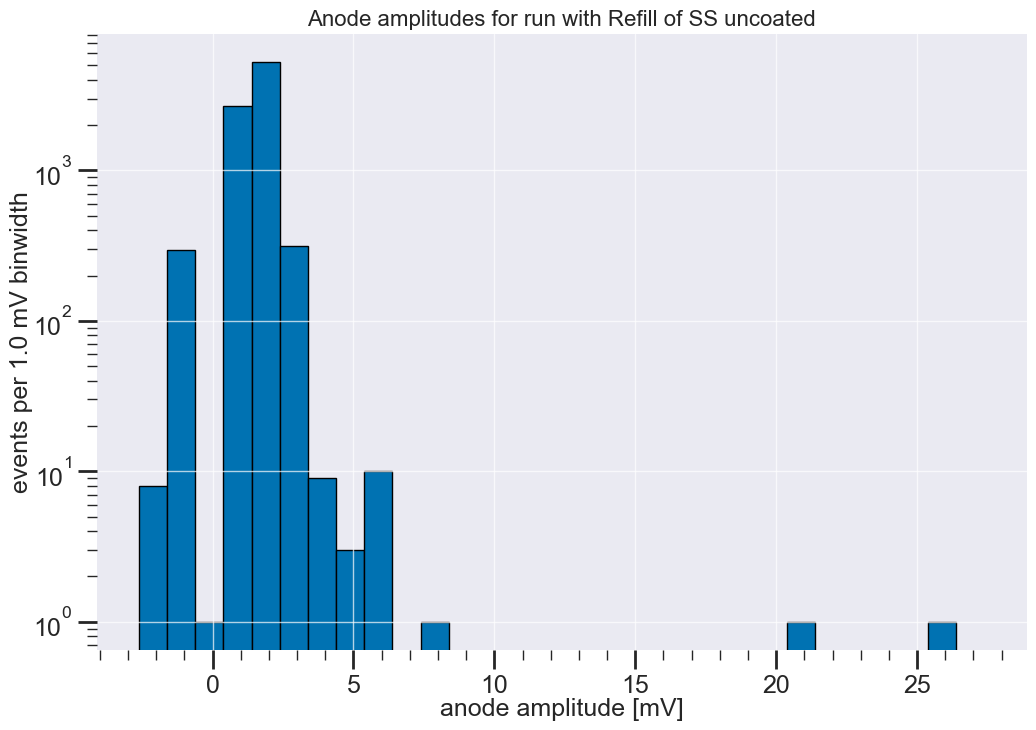

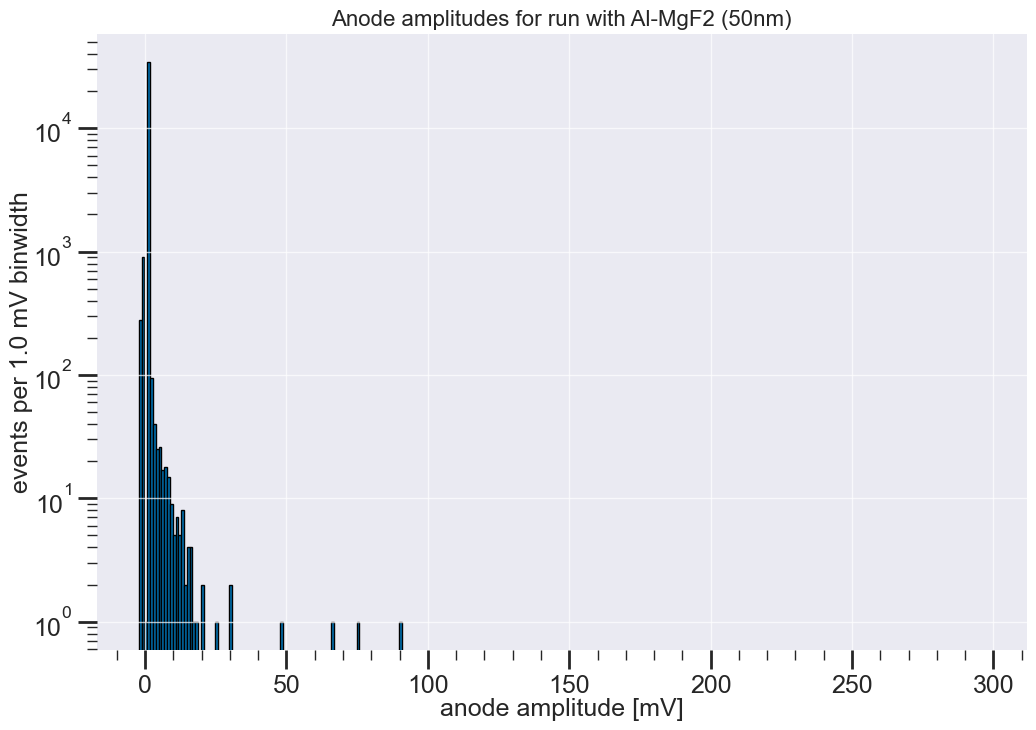

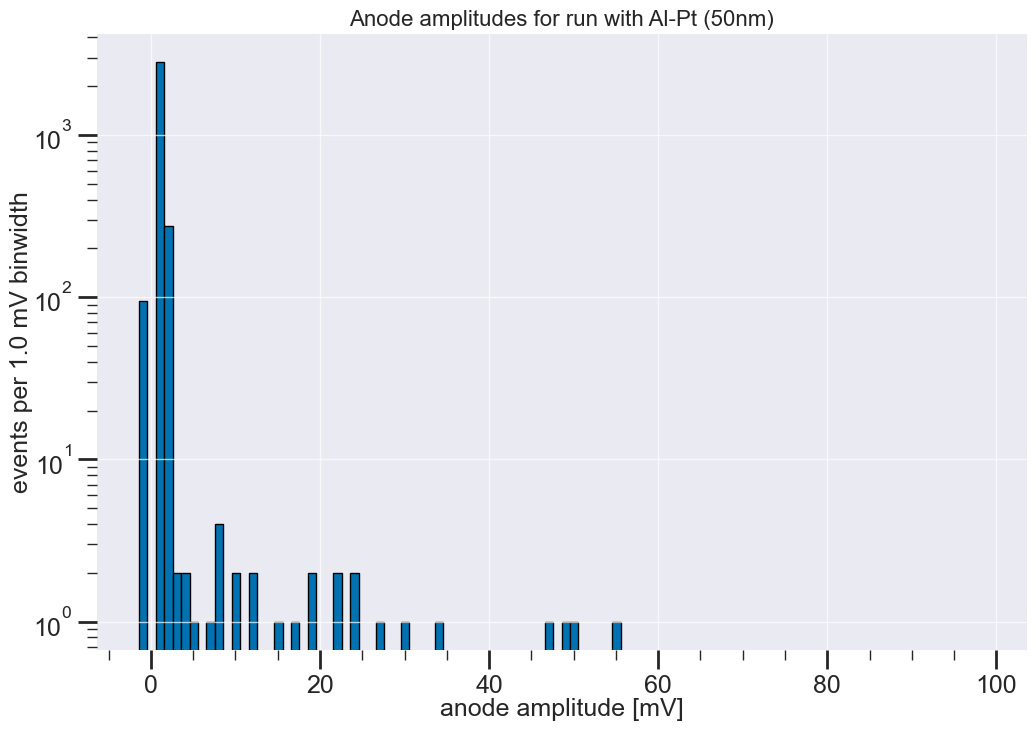

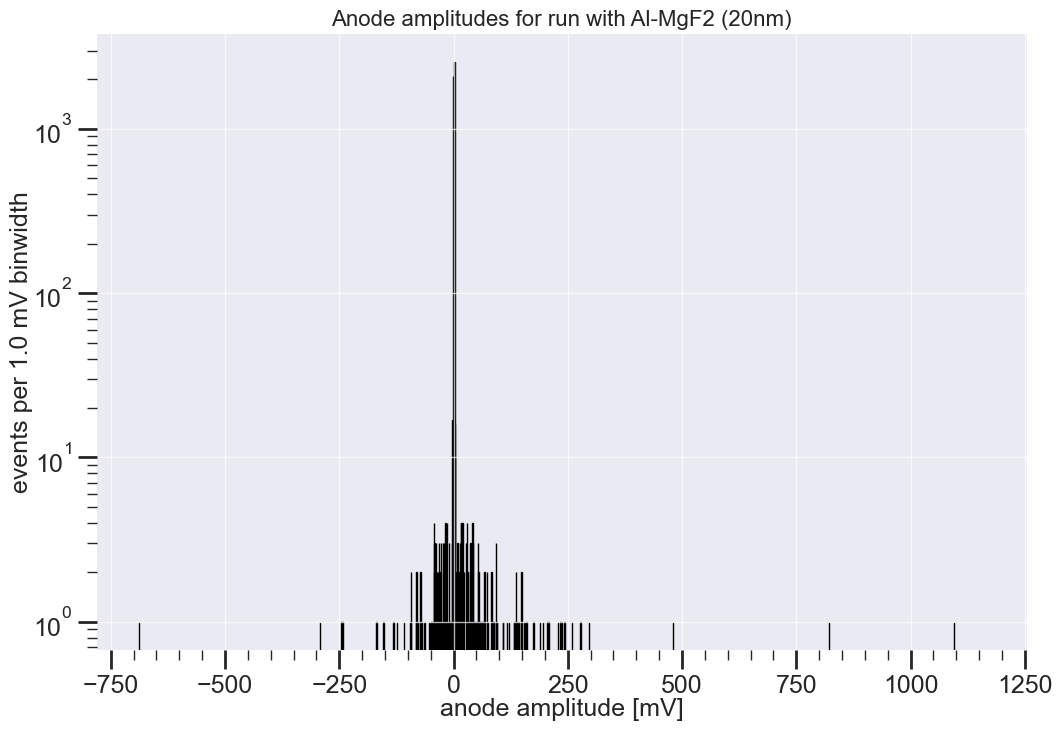

In [7]:
for run, ana in anas.items():
    fig, ax = plt.subplots()
    d = ana.df
    ampdf = d[~d["ch3 amp"].isna()]
    h = np.array(ampdf["ch3 amp"])
    binwidth = 1 #mV
    #protect against huge bounds and misreconstructed amplitudes
    bins = np.arange(np.min(h), np.max(h), binwidth)
    ax.hist(h, bins=bins)

    ax.set_xlabel("anode amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("Anode amplitudes for run with " + ana.title)
    ax.set_yscale('log')
    plt.show()

## Peak multiplicities

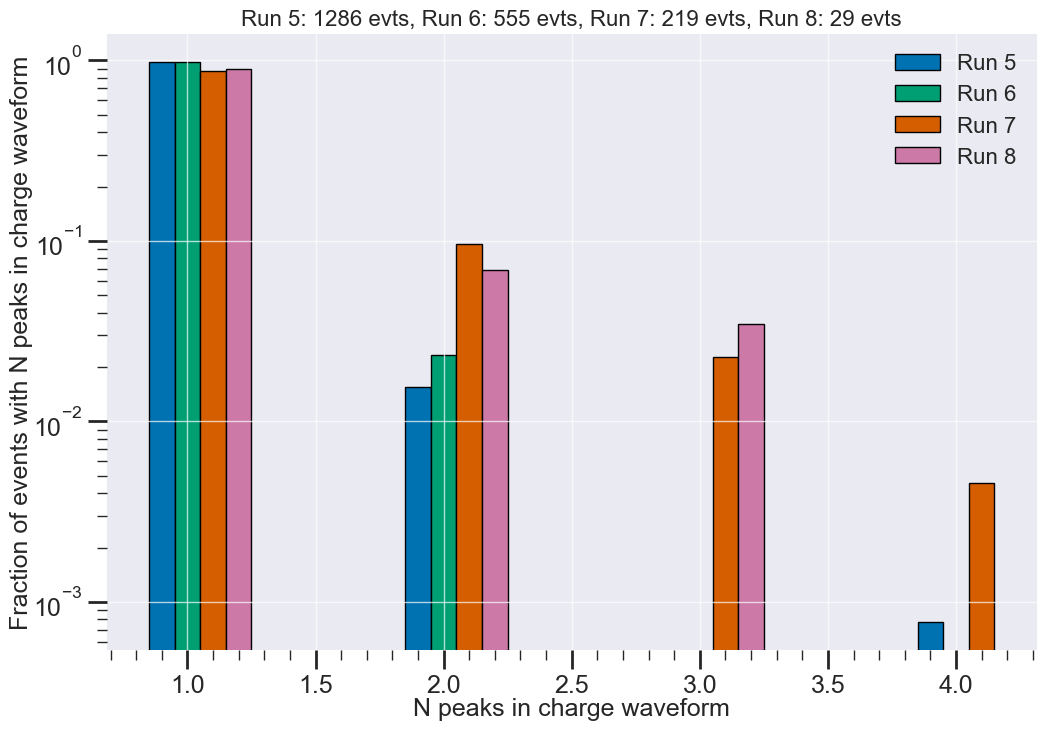

In [16]:
#Multiplicities
fig, ax = plt.subplots()
barwidth = 0.1
total_events_run = {}
for i, (run, ana) in enumerate(anas.items()):
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    npeaks_set = list(set(npeaks))
    npeaks_count = {}
    total_nonzero = 0
    for n in npeaks_set:
        npeaks_count[n] = len(np.where(npeaks == n)[0])
        if(n != 0):
            total_nonzero += npeaks_count[n]
    plotlist = []
    for n in npeaks_count:
        if(n == 0): continue
        plotlist.append(npeaks_count[n]/total_nonzero)
    
    total_events_run[run] = total_nonzero


    pos = np.array([_ for _ in npeaks_count if _ != 0])
    ax.bar(pos + (i - 1)*barwidth, plotlist, barwidth, label="Run {:d}".format(run))

ax.legend()
ax.set_yscale('log')
ax.set_ylabel("Fraction of events with N peaks in charge waveform")
ax.set_xlabel("N peaks in charge waveform")
ax.set_title("Run 5: {:d} evts, Run 6: {:d} evts, Run 7: {:d} evts, Run 8: {:d} evts".format(total_events_run[5],total_events_run[6],total_events_run[7], total_events_run[8]))
plt.show()


In [ ]:
#Multiplicities

for i, (run, ana) in enumerate(anas.items()):
    fig, ax = plt.subplots()
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    kv = np.array(d["ch3 hv"])
    kv = kv[~np.equal(kv, None)]
    ax.scatter(kv, npeaks, alpha=0.5, s=30)
    

    #ax.legend()
    ax.set_ylabel("N peaks in charge waveform")
    ax.set_xlabel("HV applied [kV]")
    ax.set_title("Run {:d}".format(run))
    #ax.set_xlim([5, 15])
    plt.show()


# Waveform plotting tools, which require cluster operation for access to prereduced

In [ ]:
#waveform plotting tool (not tested, need cluster where all prereduced data sits. )
for run, ana in anas.items():
    d = ana.df
    mask = (d["ch3 amp"] > 20)
    sw_chs = [3]
    events = ana.get_waveforms_from_cuts(mask, sw_chs)[3]
    fig, ax = plt.subplots()
    for ev in events:
        times = np.arange(0, ev["dT"]*1e6*len(ev["Data"][0]), ev["dT"]*1e6)
        ax.plot(times, ev["Data"][0])

    ax.legend()
    ax.set_xlabel("time [us]")
    ax.set_ylabel('[mV]')
    ax.set_title("run {:d} ({:d} events)".format(run, len(events)))
    plt.show()

## History plots

# Drafting

/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


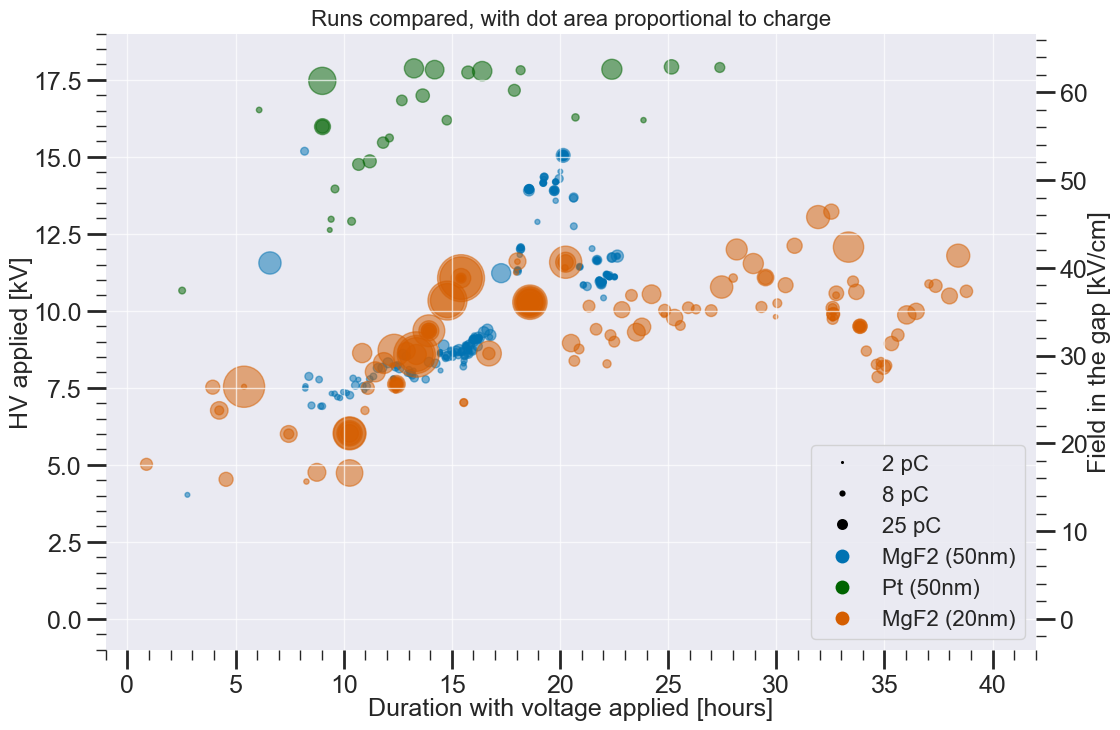

In [112]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10

fig, ax = plt.subplots()
ax.set_ylim([-1, 19]) #fixed axis for all
ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    ana.load_hv_textfiles()
    ana.identify_ramps(ref='v_mon')
    tdmap = ana.time_duration_map
    #ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color='k', linewidth=0.7, alpha=0.5)

    #negative polar events
    mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    #ax.plot(hv_event_durs, d_hv, 'k-', alpha=0.3)
    #negative polar events
    mask = (d["ch3 n negpeaks"] == 0) & (d["ch3 n pospeaks"] > 0) 
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    
    #ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='v', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    #ax.plot(hv_event_durs, d_hv,  'k-', alpha=0.3)
    legend_elements.append(Line2D([0], [0], marker='o', linewidth=0, color=colors[i], markersize=10, label=ana.title))


# Add legend with custom legend entries and solid color bounding background box
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("Runs compared, with dot area proportional to charge")
plt.show()


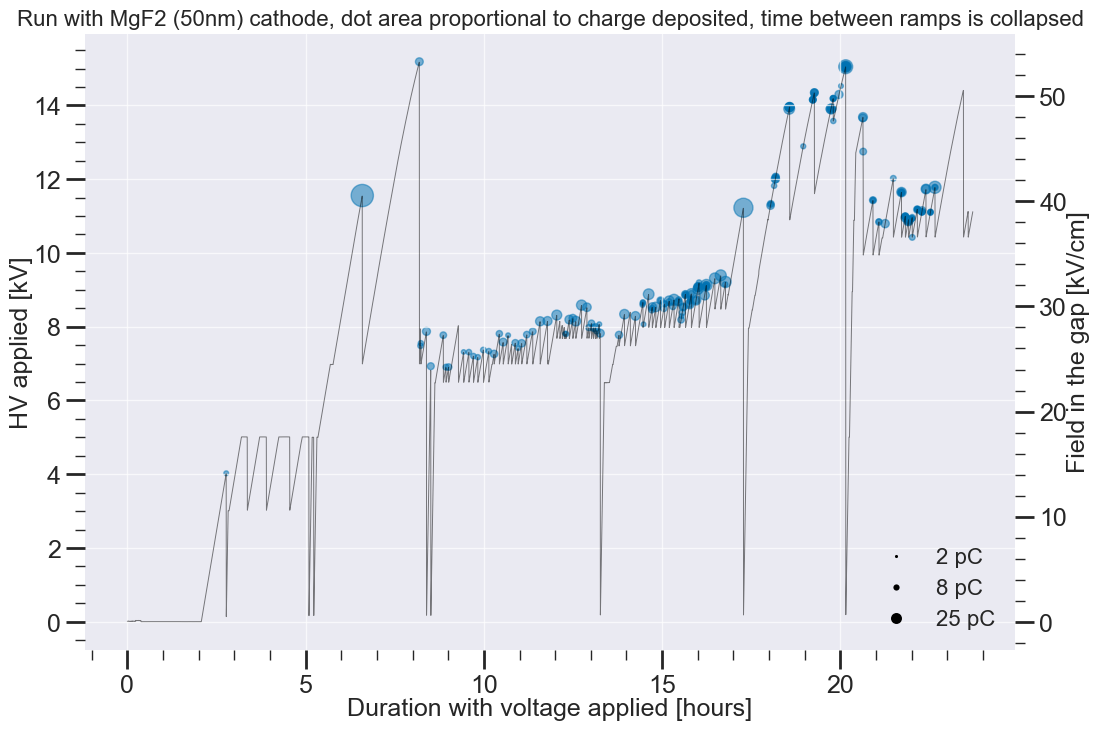

(4.027740861702246, 11.556222447722648, 15.184550554931723, 7.4833835764288485, 7.553657604451002, 7.872908768744506, 6.930105946820552, 7.770868236519306, 6.903611830508924, 6.906460976054652, 7.3170316609835995, 7.31096621196096, 7.203888272920421, 7.174119107862673, 7.367802259702921, 7.336990366120963, 7.262501365049283, 7.810859078380178, 7.583221161067132, 7.768121895194347, 7.561749765253589, 7.41581183078003, 7.550955322077701, 7.786097947503303, 7.87298220033075, 8.146544231671774, 8.15415174400517, 8.316185882180248, 7.810403802545545, 7.803236879729467, 8.192541777286312, 8.231622067477879, 8.15100887211453, 8.585856039451178, 8.528197557943459, 7.976094833714715, 8.093218213751575, 7.971571448002929, 7.976682286404568, 7.901312106298102, 8.067076569053885, 7.823650860701424, 7.777359588741973, 8.340183324560154, 8.293005840882744, 8.59322353802535, 8.624314471635097, 8.653628360858093, 8.662748563867918, 8.064060841335053, 8.881442513977953, 8.461795684990939, 8.51512170291

In [114]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10



# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7,8,9]):
    fig, ax = plt.subplots()
    #ax.set_ylim([-1, 19]) #fixed axis for all
    #ax.set_xlim([-1, 42])
    
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    ana.load_hv_textfiles()
    ana.identify_ramps(ref='v_mon')
    tdmap = ana.time_duration_map
    ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color='k', linewidth=0.7, alpha=0.5)

    #negative polar events
    mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])

    ax2 = ax.twinx()
    E_f = lambda V:V/0.285
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(E_f(ymin), E_f(ymax))
    ax2.plot([], [])
        
    # Add legend with custom legend entries
    ax.legend(handles=legend_elements, loc='lower right')
    ax.set_ylabel("HV applied [kV]")
    ax2.set_ylabel("Field in the gap [kV/cm]")
    ax2.grid(False)
    ax.set_xlabel("Duration with voltage applied [hours]")
    ax.set_title("Run with {} cathode, dot area proportional to charge deposited, time between ramps is collapsed".format(ana.title))
    plt.show()

    hv_event_durs, d_hv, d_ch = zip(*sorted(zip(hv_event_durs, d_hv, d_ch)))
    print(d_hv)
    break


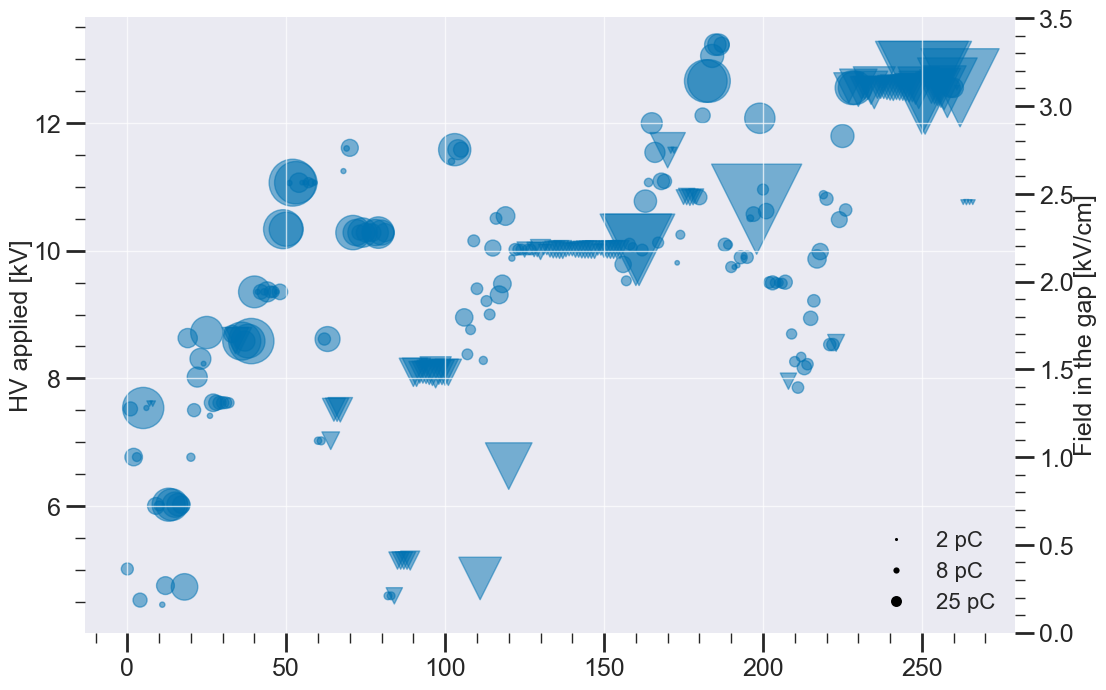

In [85]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

charge_dot_scale = 10

fig, ax = plt.subplots()
#ax.set_ylim([-1, 18]) #fixed axis for all
#ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([9]):
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]

    #get all events with any amount of charge
    mask = ((d["ch3 n negpeaks"] > 0) | (d["ch3 n pospeaks"] == 0)) & (np.abs(d["ch3 charge"]) > 1)
    d_ch_n = np.array(d[mask]["ch3 charge"])
    d_sec_n = np.array(d[mask]["ch3 seconds"])
    d_hv_n = np.array(d[mask]["ch3 hv"])

    #get all events with any amount of charge
    mask = ((d["ch3 n negpeaks"] == 0) | (d["ch3 n pospeaks"] > 0)) & (np.abs(d["ch3 charge"]) > 1)
    d_ch_p = np.array(d[mask]["ch3 charge"])
    d_sec_p = np.array(d[mask]["ch3 seconds"])
    d_hv_p = np.array(d[mask]["ch3 hv"])

    d_ch = np.concatenate((d_ch_n, d_ch_p))
    d_sec = np.concatenate((d_sec_n, d_sec_p))
    d_hv = np.concatenate((d_hv_n, d_hv_p))

    #sort all three lists by the order of d_sec
    d_sec, d_ch, d_hv = zip(*sorted(zip(d_sec, d_ch, d_hv)))

    #reseparate out into 3 lists based on n or p based on whether d_ch is negative or positive
    n_idxs = np.where(np.array(d_ch) < 0)
    p_idxs = np.where(np.array(d_ch) > 0)
    d_ch_n = np.array(d_ch)[n_idxs]
    d_ch_p = np.array(d_ch)[p_idxs]
    d_sec_n = np.array(d_sec)[n_idxs]
    d_sec_p = np.array(d_sec)[p_idxs]
    d_hv_n = np.array(d_hv)[n_idxs]
    d_hv_p = np.array(d_hv)[p_idxs]

    ax.scatter(n_idxs, d_hv_n, s=list(np.abs(np.array(d_ch_n))*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    ax.scatter(p_idxs, d_hv_p, s=list(np.array(d_ch_p)*charge_dot_scale), marker='v', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    
    


# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
#ax.set_xlabel("Duration with voltage applied [hours]")
#ax.set_title("Runs compared: charge events as circles, high voltage applied as lines")
plt.show()

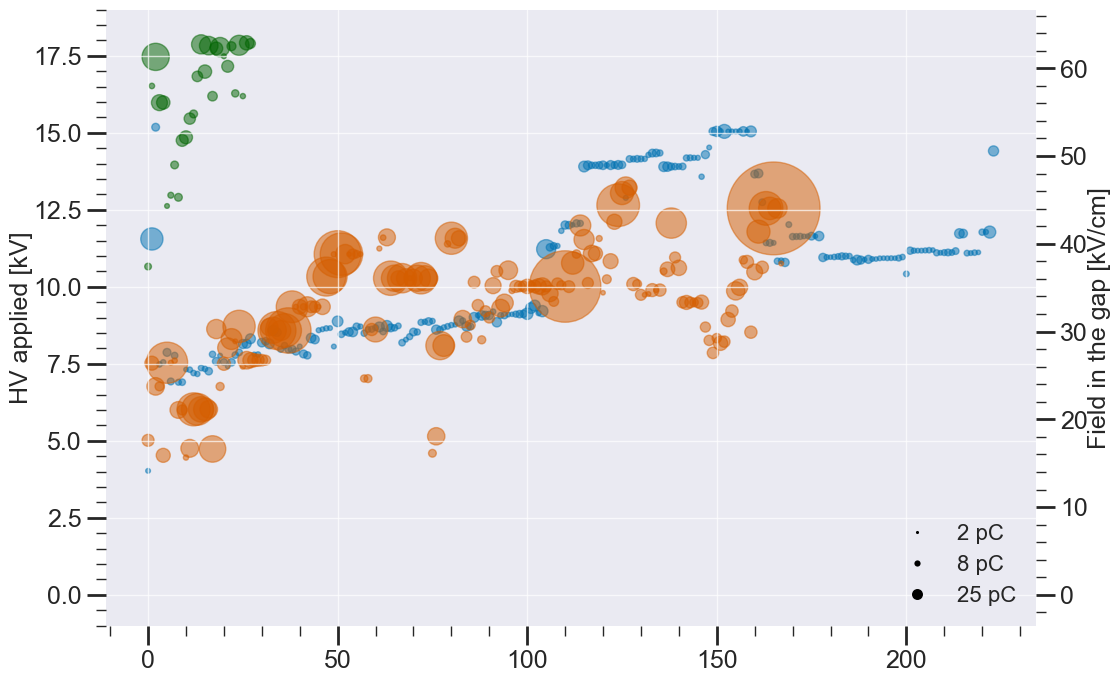

In [96]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10

fig, ax = plt.subplots()
ax.set_ylim([-1, 19]) #fixed axis for all
#ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]

    #get all events with any amount of charge
    mask = ((d["ch3 n negpeaks"] > 0) | (d["ch3 n pospeaks"] == 0)) & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.array(d[mask]["ch3 charge"])
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])

    #sort all three lists by the order of d_sec
    d_sec, d_ch, d_hv = zip(*sorted(zip(d_sec, d_ch, d_hv)))

    ax.scatter(range(len(d_hv)), d_hv, s=list(np.abs(np.array(d_ch))*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    
    


# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
#ax.set_xlabel("Duration with voltage applied [hours]")
#ax.set_title("Runs compared: charge events as circles, high voltage applied as lines")
plt.show()

In [78]:
print(np.min(np.abs(d[np.abs(d["ch3 charge"]) > 1]["ch3 charge"])))

1.0486299907772558


## Comparisons with analytic stored charge and energy

In [39]:
C = 20 #pF
cq = 1.6e-19

dQs = np.array(np.linspace(0.5, 50, 100)) #pC
Vs = np.array(np.linspace(0, 18, 100)) #kV
Es = Vs/0.285
Qs = C*Vs*1000 #pC

U = 0.5*(Qs**2)/(C*1e6) #uJ

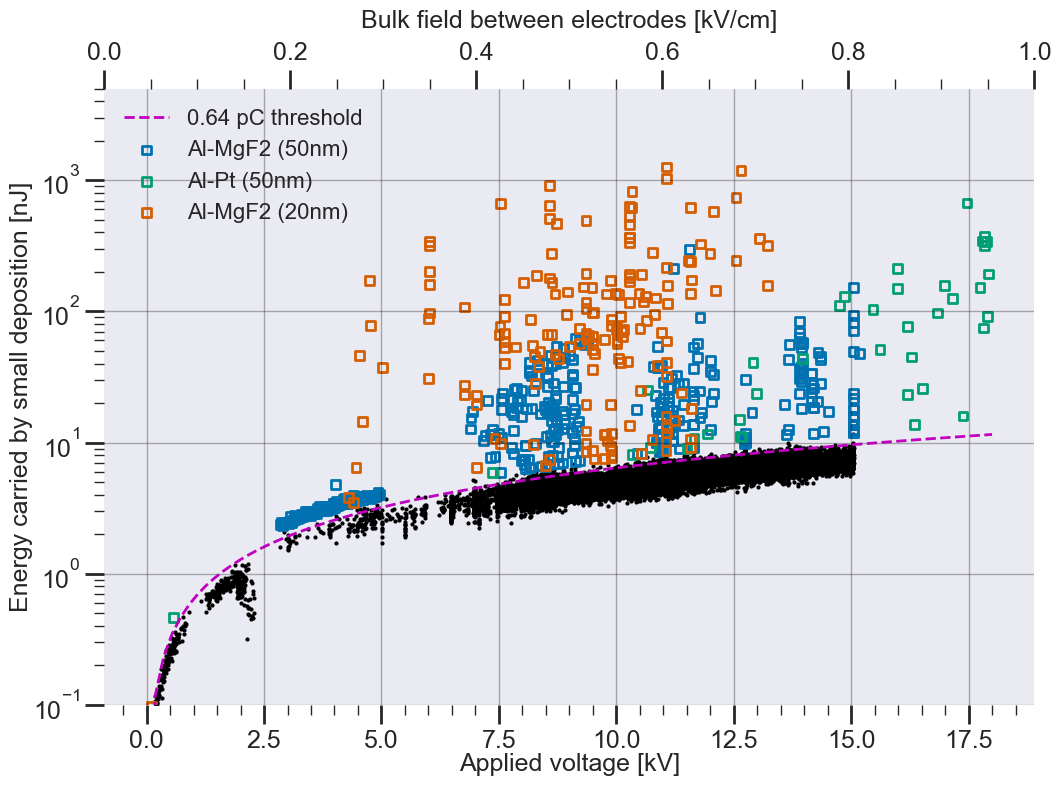

In [40]:
#get charge magnitudes and calculate partial energy
#deposited for each charge event in a run based on what
#voltage / total stored charge is in the gap at that moment. 




dQs = [1, 5, 15, 25, 50]
fig, ax = plt.subplots()
ax2 = ax.twiny()
for dq in dQs:
    dU = dq*Qs/(C*1e6) #uJ
    #ax.plot(Vs, dU*1000, label="{:d} pC".format(dq))
    #ax2.plot(Es, dU*1000, linewidth=0)

for run, ana in anas.items():
    d = ana.df
    if(run < 7): continue
    mask = (~d["ch3 energy"].isna())
    dd = d[mask]
    if(run == 7):
        hardware_threshold = 0.64 #pC
        mask = (np.abs(dd["ch3 amp"]) < 2)
        du_evts = dd[mask]
        ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"]), color='k')
        ax.plot(Vs, hardware_threshold*Vs, 'm--', label="{:.2f} pC threshold".format(hardware_threshold))

    mask = (np.abs(dd["ch3 amp"]) > 2)
    du_evts = dd[mask]
    ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"]),marker='s', linewidth=2, facecolors='None', s=40, edgecolors=colors[run-7], label=ana.title)

ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Energy carried by small deposition [nJ]")
ax.grid(color='k', alpha=0.3)
ax.set_yscale('log')
ax.set_ylim([1e-1, 5e3])
ax.legend()
plt.show()

/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_49349/3797607958.py:14: RuntimeWarning: invalid value encountered in divide
  ax.plot(Vs, dU/U, label="{:d} pC".format(dq))
/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_49349/3797607958.py:15: RuntimeWarning: invalid value encountered in divide
  ax2.plot(Es, dU/U, linewidth=0)
/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_49349/3797607958.py:33: RuntimeWarning: invalid value encountered in divide
  ax.plot(Vs, hardware_threshold*Vs*1000/(0.5*C*((Vs*1000)**2)), 'm--', label="{:.2f} pC threshold".format(hardware_threshold))


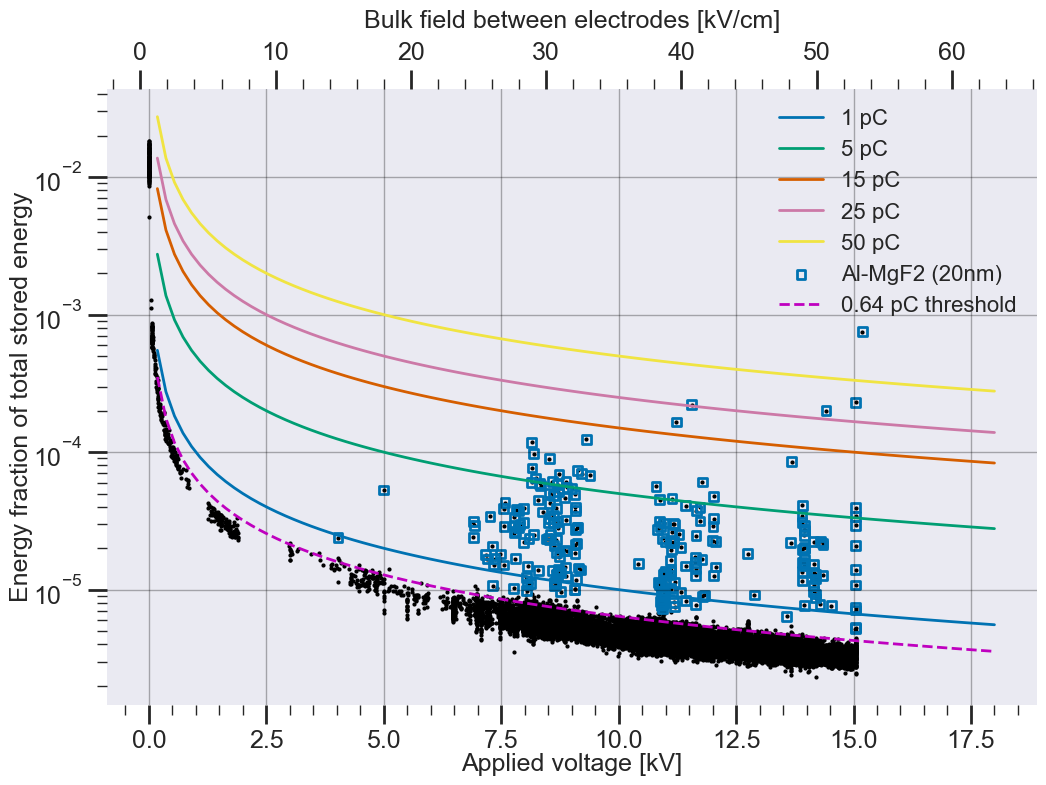

In [13]:
#get charge magnitudes and calculate partial energy
#deposited for each charge event in a run based on what
#voltage / total stored charge is in the gap at that moment. 

#Do the same as above but normalize relative to the total energy stored in the cap. 
#i.e. calculate fractional energy carried relative to the total energy. 


dQs = [1, 5, 15, 25, 50]
fig, ax = plt.subplots()
ax2 = ax.twiny()
for dq in dQs:
    dU = dq*Qs/(C*1e6) #uJ
    ax.plot(Vs, dU/U, label="{:d} pC".format(dq))
    ax2.plot(Es, dU/U, linewidth=0)


d = anas[7].df

mask = (~d["ch3 energy"].isna())
du_evts = d[mask]
total_energy = 0.5*C*(np.array(du_evts["ch3 hv"])*1000)**2
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"])*1000/total_energy, color='k')

#above trip threshold, color differently. 
mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]
total_energy = 0.5*C*(np.array(du_evts["ch3 hv"])*1000)**2
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"])*1000/total_energy, color='r')


hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold*Vs*1000/(0.5*C*((Vs*1000)**2)), 'm--', label="{:.2f} pC threshold".format(hardware_threshold))


ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Energy fraction of total stored energy")
ax.grid(color='k', alpha=0.3)
ax.set_yscale('log')
#ax.set_ylim([1e-1, 3e3])
ax.legend()
plt.show()

/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_49349/1074455559.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))


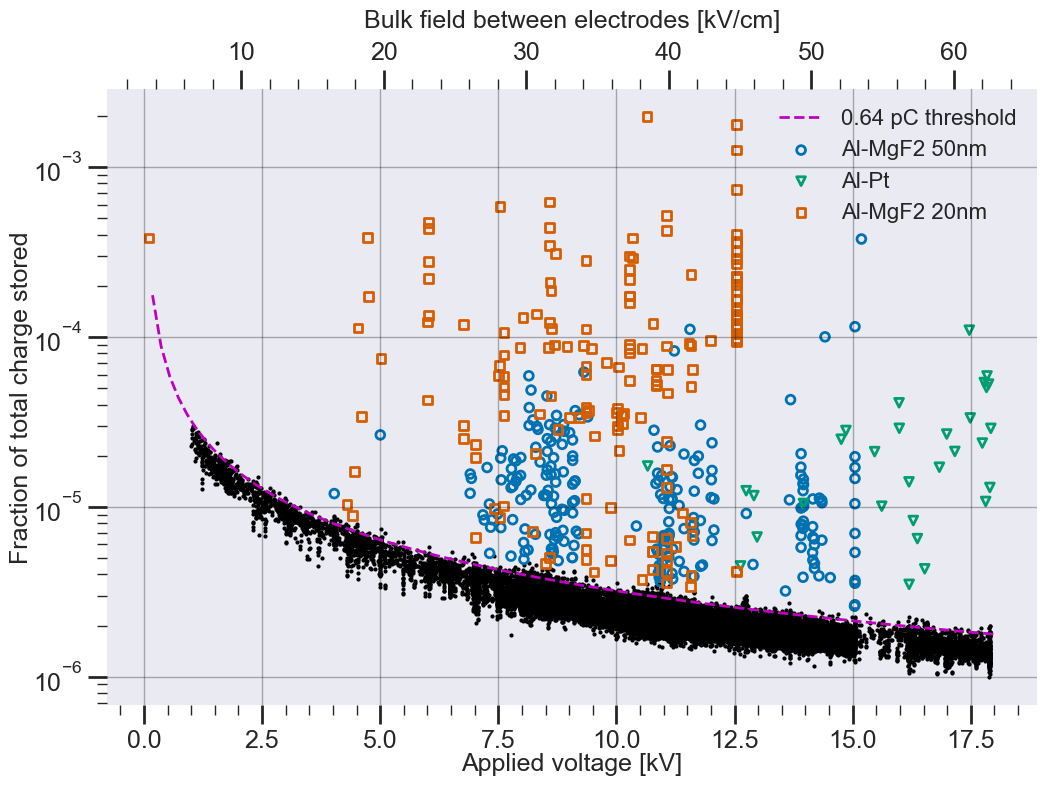

In [28]:
#similar as above, but now fractional stored charge. 

fig, ax = plt.subplots()


ax2 = ax.twiny()
hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))

d = anas[7].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='o', linewidth=2, facecolors='None', s=40, edgecolors=colors[0], label="Al-MgF2 50nm")


d = anas[8].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='v', linewidth=2, facecolors='None', s=40, edgecolors=colors[1], label="Al-Pt")

d = anas[9].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1) & (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='s', linewidth=2, facecolors='None', s=40, edgecolors=colors[2], label="Al-MgF2 20nm")



ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Fraction of total charge stored")
ax.legend()
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
plt.show()

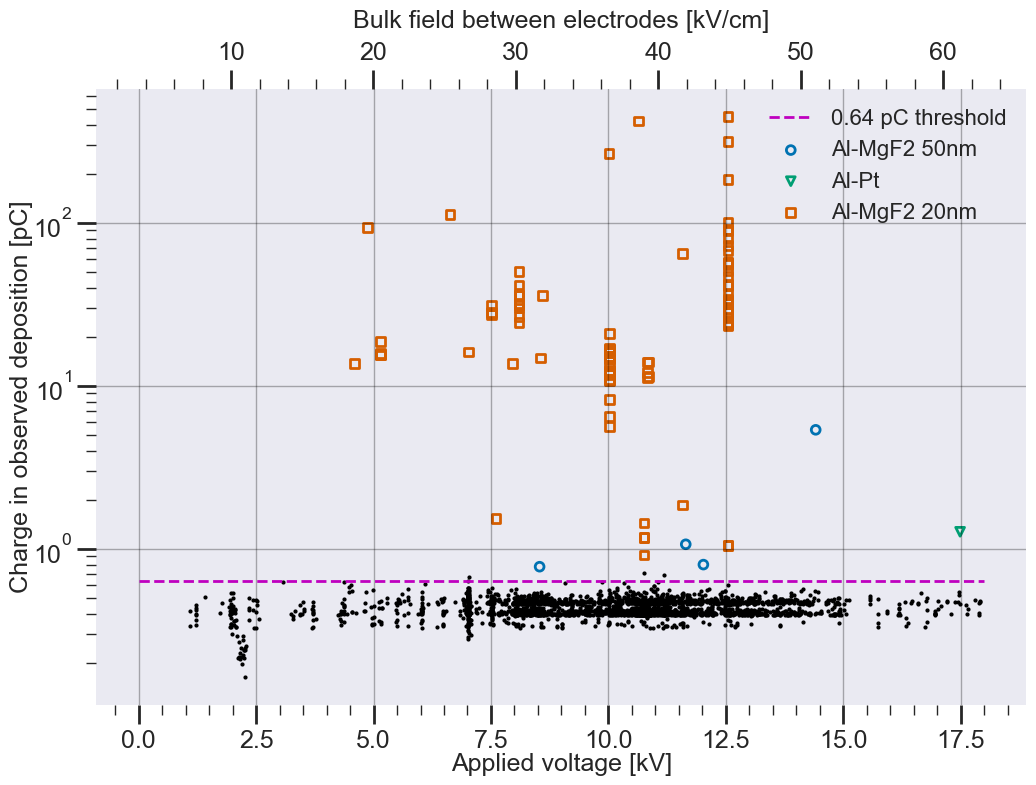

In [41]:
#similar as above, but now stored charge.

fig, ax = plt.subplots()


ax2 = ax.twiny()
hardware_threshold = 0.64 #pC
ax.plot(Vs, [hardware_threshold]*len(Vs), 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))

d = anas[7].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='o', linewidth=2, facecolors='None', s=40, edgecolors=colors[0], label="Al-MgF2 50nm")


d = anas[8].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='v', linewidth=2, facecolors='None', s=40, edgecolors=colors[1], label="Al-Pt")

d = anas[9].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1) & (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='s', linewidth=2, facecolors='None', s=40, edgecolors=colors[2], label="Al-MgF2 20nm")



ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Charge in observed deposition [pC]")
ax.legend()
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
plt.show()

# Light analysis

In [106]:
import time
#PMT rates

ana = anas[9]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 130.49 seconds


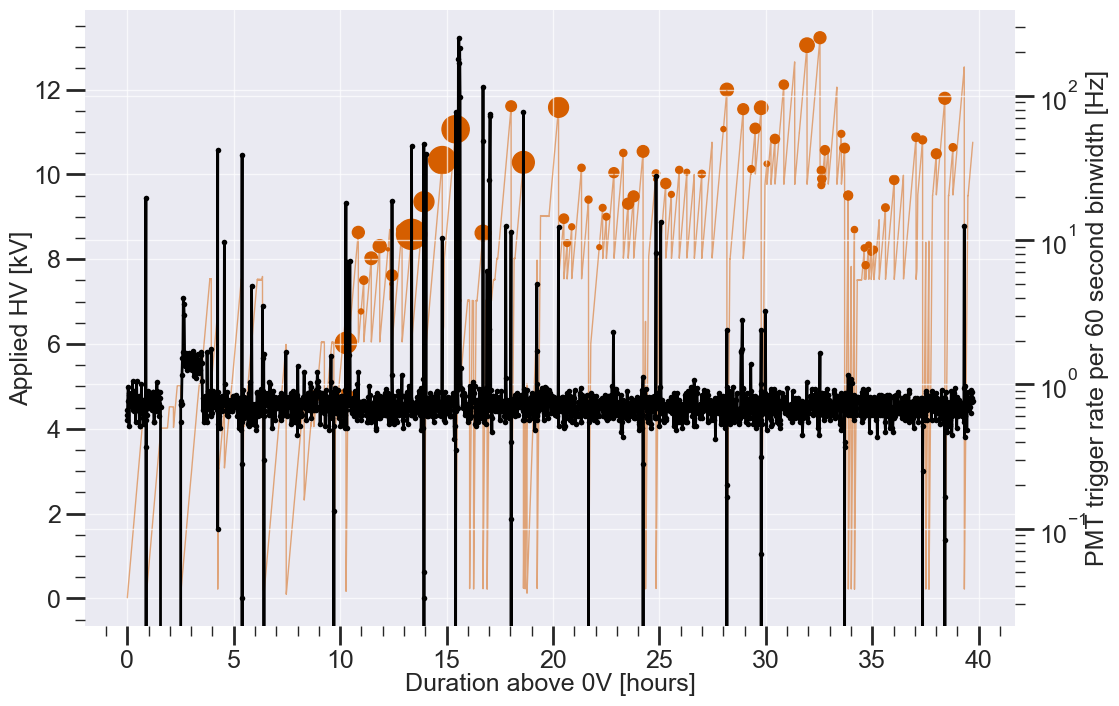

In [108]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[2], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[2], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
ax2.set_yscale('log')
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
plt.show()


In [99]:
import time
#PMT rates

ana = anas[7]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 30.27 seconds


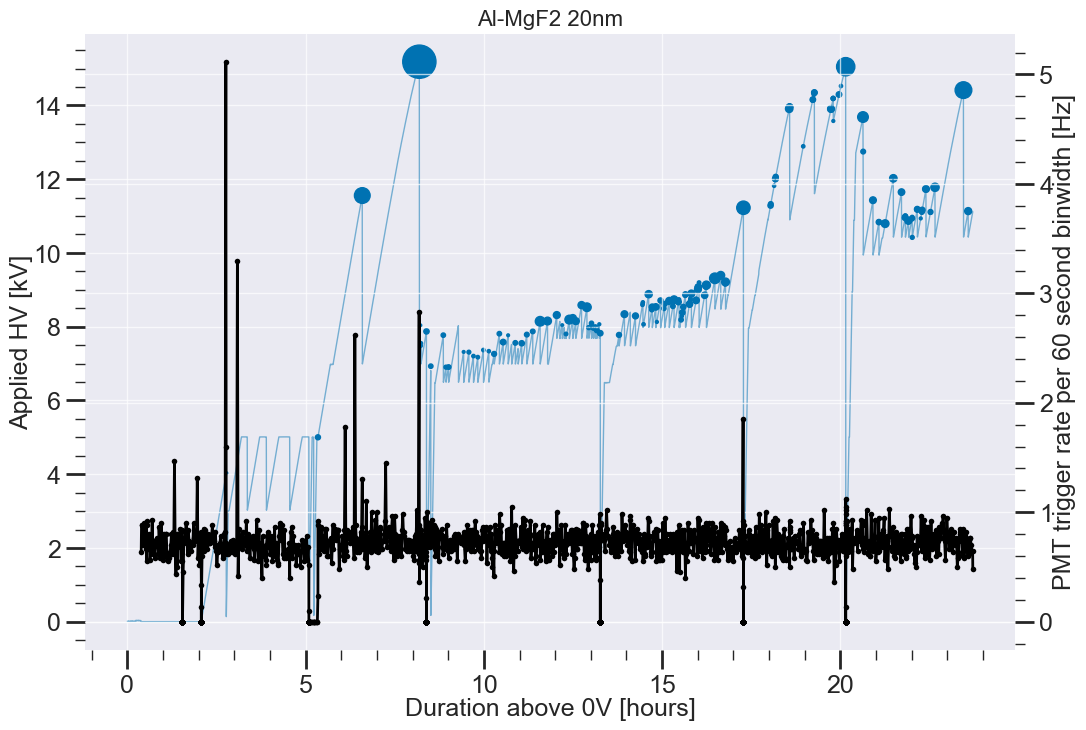

In [102]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[0], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[0], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
#ax2.set_xlim([0, 5])
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
ax.set_title("Al-MgF2 20nm")
plt.show()


In [103]:
import time
#PMT rates

ana = anas[9]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 1 #seconds
bins = np.arange(min(ts_ms), min(ts_ms) + 60*60*5, rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 160.95 seconds


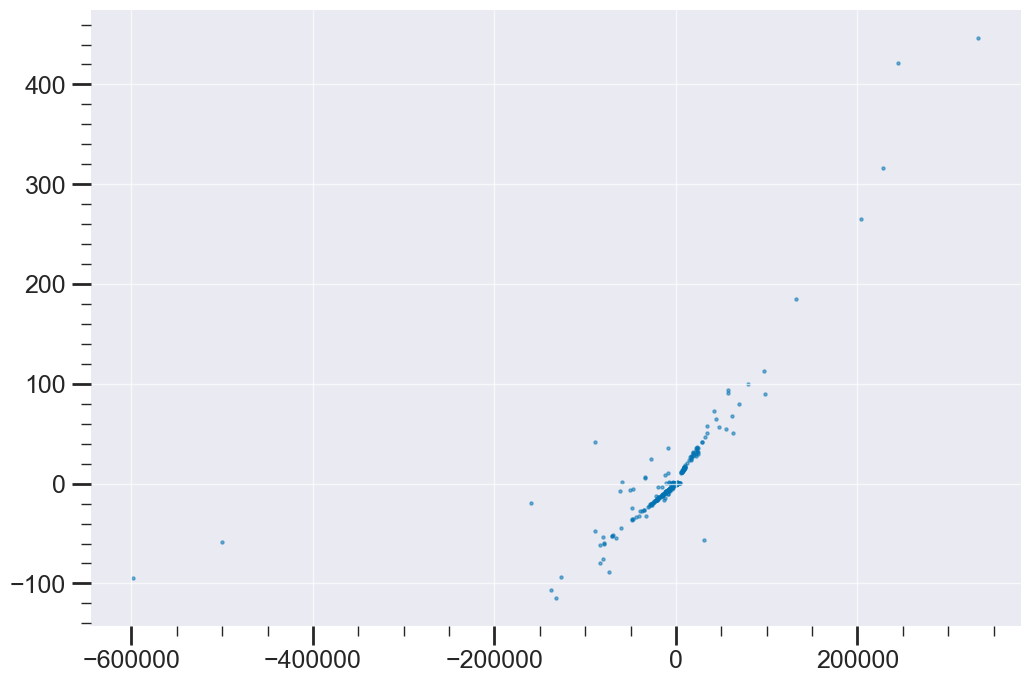

In [117]:
d = anas[9].df 
d = d[~d["ch3 full integral"].isna() & ~d["ch3 charge"].isna()]

fig, ax = plt.subplots()
ax.scatter(d["ch3 full integral"], d["ch3 charge"], s=20, alpha=0.5)
plt.show()

